# Import packages

In [83]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import json 
import re
import string

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from scipy.stats.mstats import winsorize

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from keras.layers import Layer
from keras import backend as K
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.losses import binary_crossentropy
from scipy.spatial.distance import cdist
import shap

from sklearn.model_selection import GridSearchCV
from dython.nominal import associations

# Import data

In [84]:
# Read the csv file
df = pd.read_csv('hotel_bookings.csv')

In [85]:
# Target variable
df['is_canceled'].sum()/df['is_canceled'].shape[0]

0.37041628277075134

In [86]:
# Shape and Columns
print('Shape:',df.shape)
print('Columns:',df.columns)

Shape: (119390, 32)
Columns: Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')


In [87]:
# Descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_year,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.0,2017.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0


In [88]:
# Data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [89]:
# Create date
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [90]:
# Define a dictionary mapping month names to numerical values
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Convert month names to numerical values
df['arrival_date_month'] = df['arrival_date_month'].map(month_map)

# Create date
df['dateInt']=df['arrival_date_year'].astype(str) + df['arrival_date_month'].astype(str).str.zfill(2)+ df['arrival_date_day_of_month'].astype(str).str.zfill(2)
df['date'] = pd.to_datetime(df['dateInt'], format='%Y%m%d')
df = df.drop(columns=['dateInt'])

# Data Processing

## Data Leakage

In [91]:
# Data leakage columns removal
df = df.drop(columns=['country','assigned_room_type','days_in_waiting_list','reservation_status','reservation_status_date'])

## Missing Data Analysis

In [92]:
# Count the number of missing values for each feature
missing_values = df.isnull().sum()

# Calculate the percentage of missing data for each feature
percentage_missing = (missing_values / len(df)) * 100

# Create a DataFrame to store the results
missing_data_info = pd.DataFrame({'Number of Missing Values': missing_values, 'Percentage': percentage_missing})

# Sort the DataFrame by percentage missing in descending order
missing_data_info = missing_data_info.sort_values(by='Percentage', ascending=False)

missing_data_info

,Number of Missing Values,Percentage
company,112593,94.306893
agent,16340,13.686238
children,4,0.003350
hotel,0,0.000000
is_repeated_guest,0,0.000000
total_of_special_requests,0,0.000000
required_car_parking_spaces,0,0.000000
adr,0,0.000000
customer_type,0,0.000000
deposit_type,0,0.000000


In [93]:
# Missing data imputation
df['agent'] = df['agent'].fillna(0)
df['company'] = df['company'].fillna(0)

# Children and company both fillna with 0
df = df.dropna()
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,reserved_room_type,booking_changes,deposit_type,agent,company,customer_type,adr,required_car_parking_spaces,total_of_special_requests,date
0,Resort Hotel,0,342,2015,7,27,1,0,0,2,...,C,3,No Deposit,0.0,0.0,Transient,0.00,0,0,2015-07-01
1,Resort Hotel,0,737,2015,7,27,1,0,0,2,...,C,4,No Deposit,0.0,0.0,Transient,0.00,0,0,2015-07-01
2,Resort Hotel,0,7,2015,7,27,1,0,1,1,...,A,0,No Deposit,0.0,0.0,Transient,75.00,0,0,2015-07-01
3,Resort Hotel,0,13,2015,7,27,1,0,1,1,...,A,0,No Deposit,304.0,0.0,Transient,75.00,0,0,2015-07-01
4,Resort Hotel,0,14,2015,7,27,1,0,2,2,...,A,0,No Deposit,240.0,0.0,Transient,98.00,0,1,2015-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,8,35,30,2,5,2,...,A,0,No Deposit,394.0,0.0,Transient,96.14,0,0,2017-08-30
119386,City Hotel,0,102,2017,8,35,31,2,5,3,...,E,0,No Deposit,9.0,0.0,Transient,225.43,0,2,2017-08-31
119387,City Hotel,0,34,2017,8,35,31,2,5,2,...,D,0,No Deposit,9.0,0.0,Transient,157.71,0,4,2017-08-31
119388,City Hotel,0,109,2017,8,35,31,2,5,2,...,A,0,No Deposit,89.0,0.0,Transient,104.40,0,0,2017-08-31


## Outlier Analysis

In [94]:
# Outlier analysis
index = ['adr', 'adults', 'babies', 'booking_changes', 'children', 
         'lead_time', 'previous_bookings_not_canceled', 'previous_cancellations', 
         'required_car_parking_spaces', 'stays_in_weekend_nights','stays_in_week_nights','total_of_special_requests']

for i, col in enumerate(index):
    
    # Calculate IQR and bounds
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Show outliers
    print(col, df.shape[0]-df[(df[col] >= lower_bound) & (df[col] <= upper_bound)].shape[0],round((df.shape[0]-df[(df[col] >= lower_bound) & (df[col] <= upper_bound)].shape[0])/df.shape[0]*100,2))

adr 3793 3.18
adults 29709 24.88
babies 917 0.77
booking_changes 18076 15.14
children 8590 7.2
lead_time 3005 2.52
previous_bookings_not_canceled 3620 3.03
previous_cancellations 6484 5.43
required_car_parking_spaces 7416 6.21
stays_in_weekend_nights 265 0.22
stays_in_week_nights 3354 2.81
total_of_special_requests 2877 2.41


In [95]:
import pandas as pd

# Assuming you have already calculated Q1, Q3, IQR, lower_bound, and upper_bound as you did in your code snippet

index = ['adr', 'adults', 'babies', 'booking_changes', 'children', 
         'lead_time', 'previous_bookings_not_canceled', 'previous_cancellations', 
         'required_car_parking_spaces', 'stays_in_weekend_nights','stays_in_week_nights','total_of_special_requests']

outlier_data = []

for col in index:
    # Calculate IQR and bounds
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    # Count outliers
    outlier_count = df.shape[0] - df[(df[col] >= lower_bound) & (df[col] <= upper_bound)].shape[0]
    outlier_percent = round((outlier_count / df.shape[0]) * 100, 2)
    
    # Append data to list
    outlier_data.append([col, outlier_count, outlier_percent])
    
    

# Create dataframe
outlier_df = pd.merge(pd.DataFrame(outlier_data, columns=['Feature', 'Outlier Count', 'Outlier Percentage']),df[index].describe().T.rename_axis("Feature"),on ='Feature',how='left')

outlier_df.sort_values(by = 'Outlier Percentage', ascending = False)

,Feature,Outlier Count,Outlier Percentage,count,mean,std,min,25%,50%,75%,max
1,adults,29709,24.88,119386.0,1.856390,0.579261,0.00,2.00,2.00,2.0,55.0
3,booking_changes,18076,15.14,119386.0,0.221131,0.652315,0.00,0.00,0.00,0.0,21.0
4,children,8590,7.20,119386.0,0.103890,0.398561,0.00,0.00,0.00,0.0,10.0
8,required_car_parking_spaces,7416,6.21,119386.0,0.062520,0.245295,0.00,0.00,0.00,0.0,8.0
7,previous_cancellations,6484,5.43,119386.0,0.087121,0.844350,0.00,0.00,0.00,0.0,26.0
6,previous_bookings_not_canceled,3620,3.03,119386.0,0.137102,1.497462,0.00,0.00,0.00,0.0,72.0
10,stays_in_week_nights,1438,1.20,119386.0,2.500310,1.908289,0.00,1.00,2.00,3.0,50.0
2,babies,917,0.77,119386.0,0.007949,0.097438,0.00,0.00,0.00,0.0,10.0
0,adr,327,0.27,119386.0,101.833541,50.534664,-6.38,69.29,94.59,126.0,5400.0
5,lead_time,181,0.15,119386.0,104.014801,106.863286,0.00,18.00,69.00,160.0,737.0


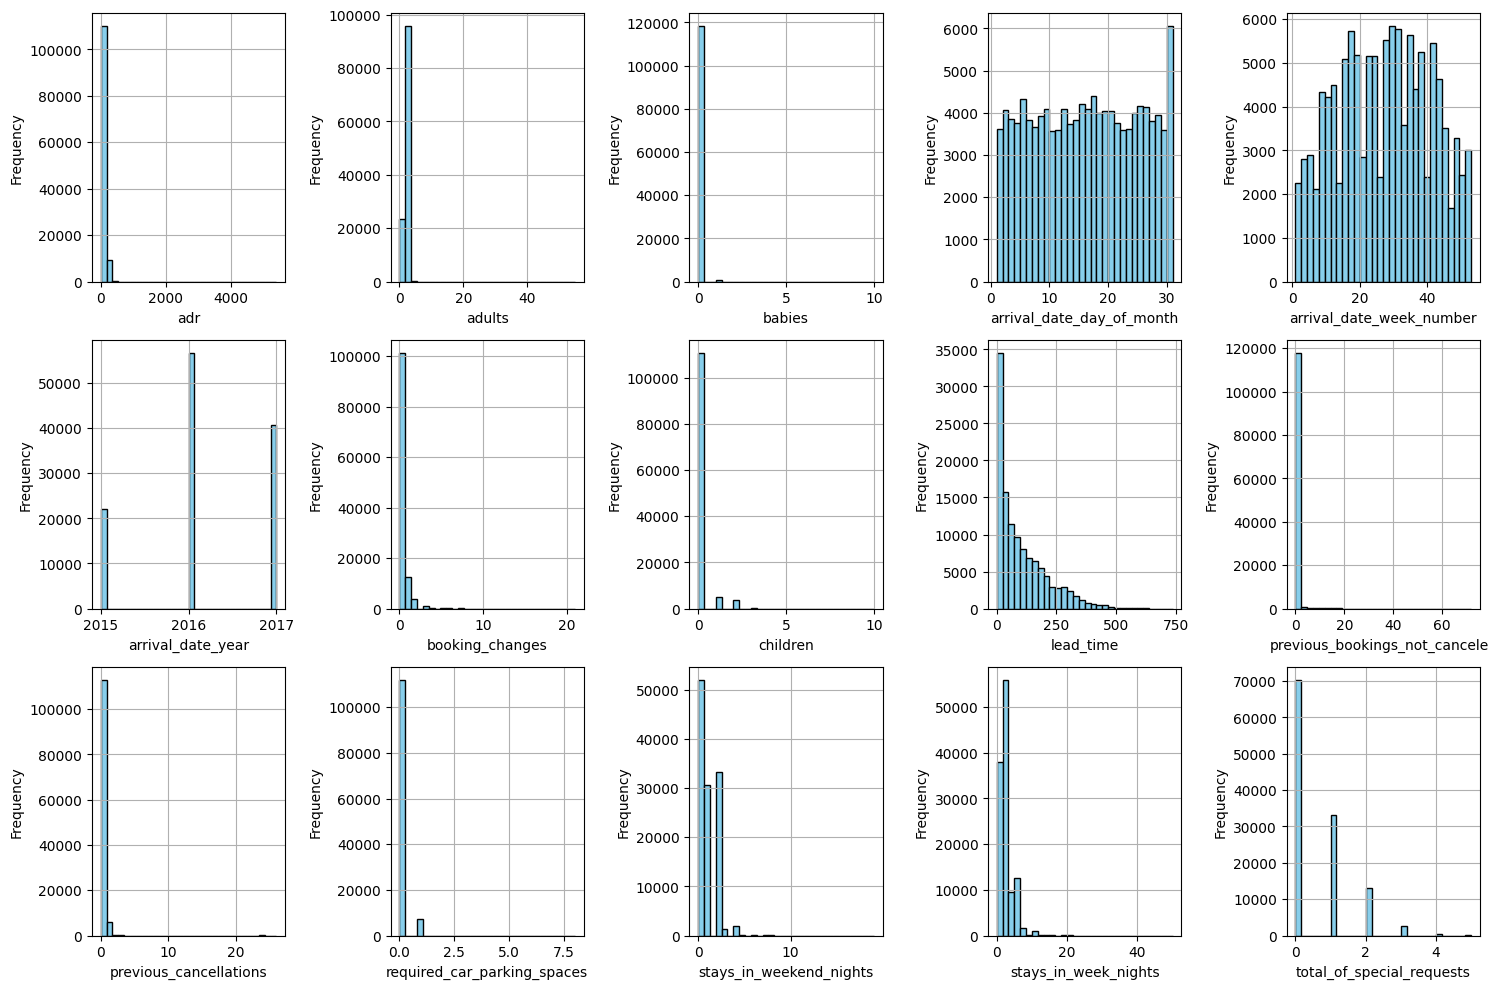

In [10]:
# Calculate number of rows required
num_cols = 5
num_rows = math.ceil(len(index) / num_cols)

# Create histograms for each feature
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for i, column in enumerate(index):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.hist(df[column], bins=30, color='skyblue', edgecolor='black')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.grid(True)

# Hide empty subplots if any
if len(index) < num_rows * num_cols:
    for i in range(len(index), num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

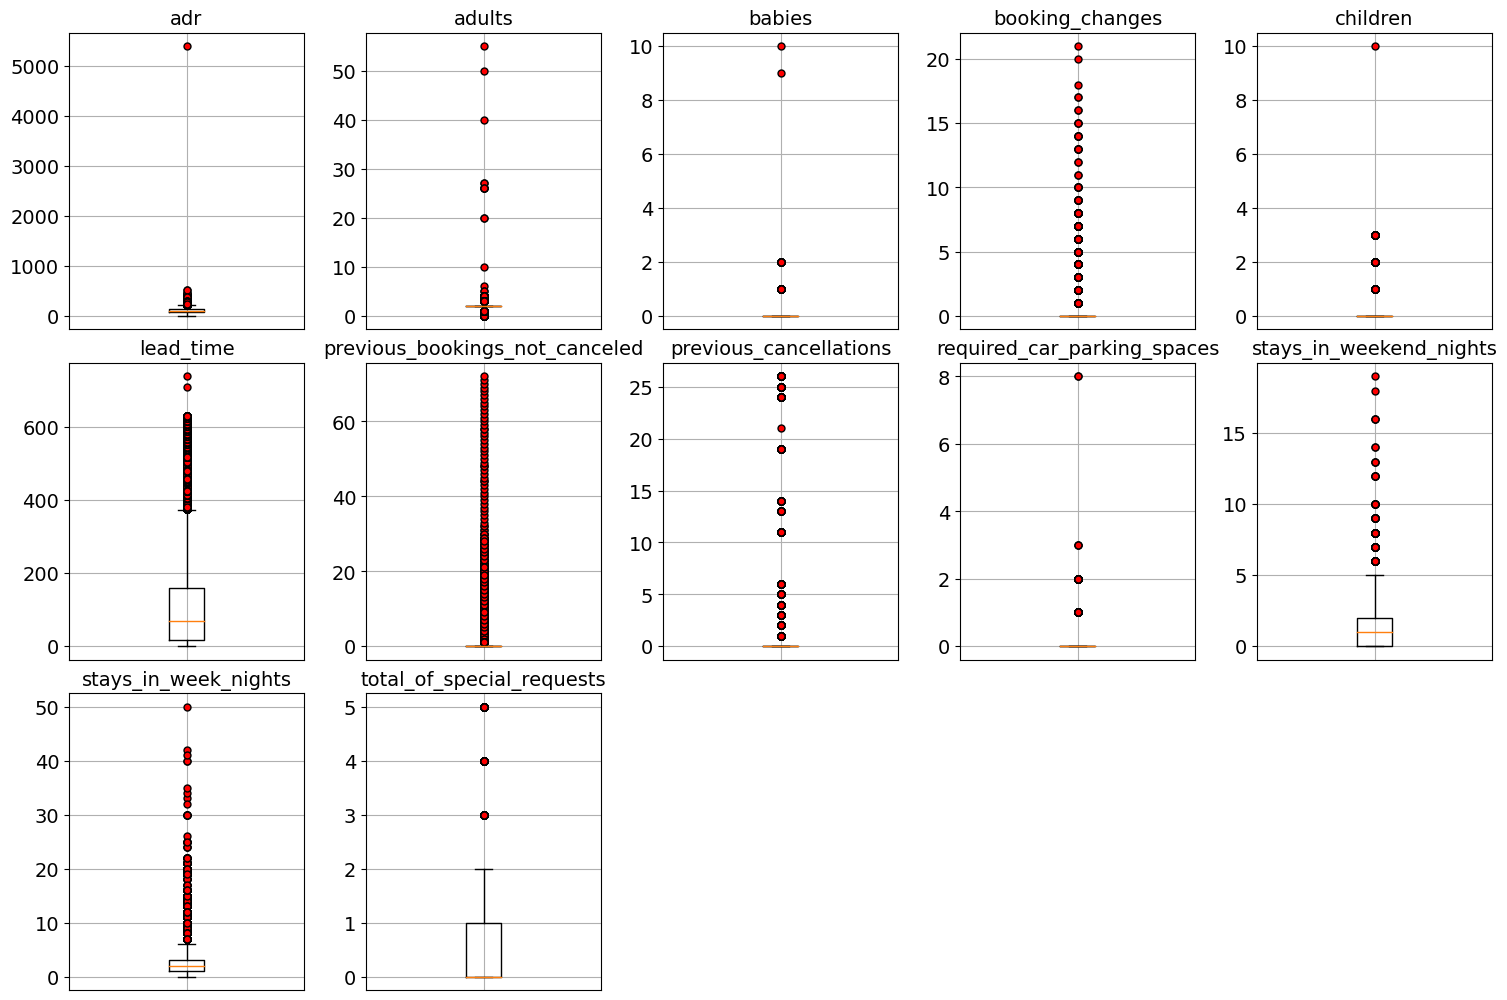

In [96]:
index = ['adr', 'adults', 'babies', 'booking_changes', 'children', 
         'lead_time', 'previous_bookings_not_canceled', 'previous_cancellations', 
         'required_car_parking_spaces', 'stays_in_weekend_nights','stays_in_week_nights','total_of_special_requests']

# Calculate number of rows required
num_cols = 5
num_rows = math.ceil(len(index) / num_cols)

# Create boxplots for each feature
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for i, column in enumerate(index):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.boxplot(df[column], vert=True, flierprops=dict(marker='o', markersize=5, linestyle='none', markerfacecolor='red'))
    ax.set_title(column, fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(True)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Hide empty subplots if any
if len(index) < num_rows * num_cols:
    for i in range(len(index), num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()


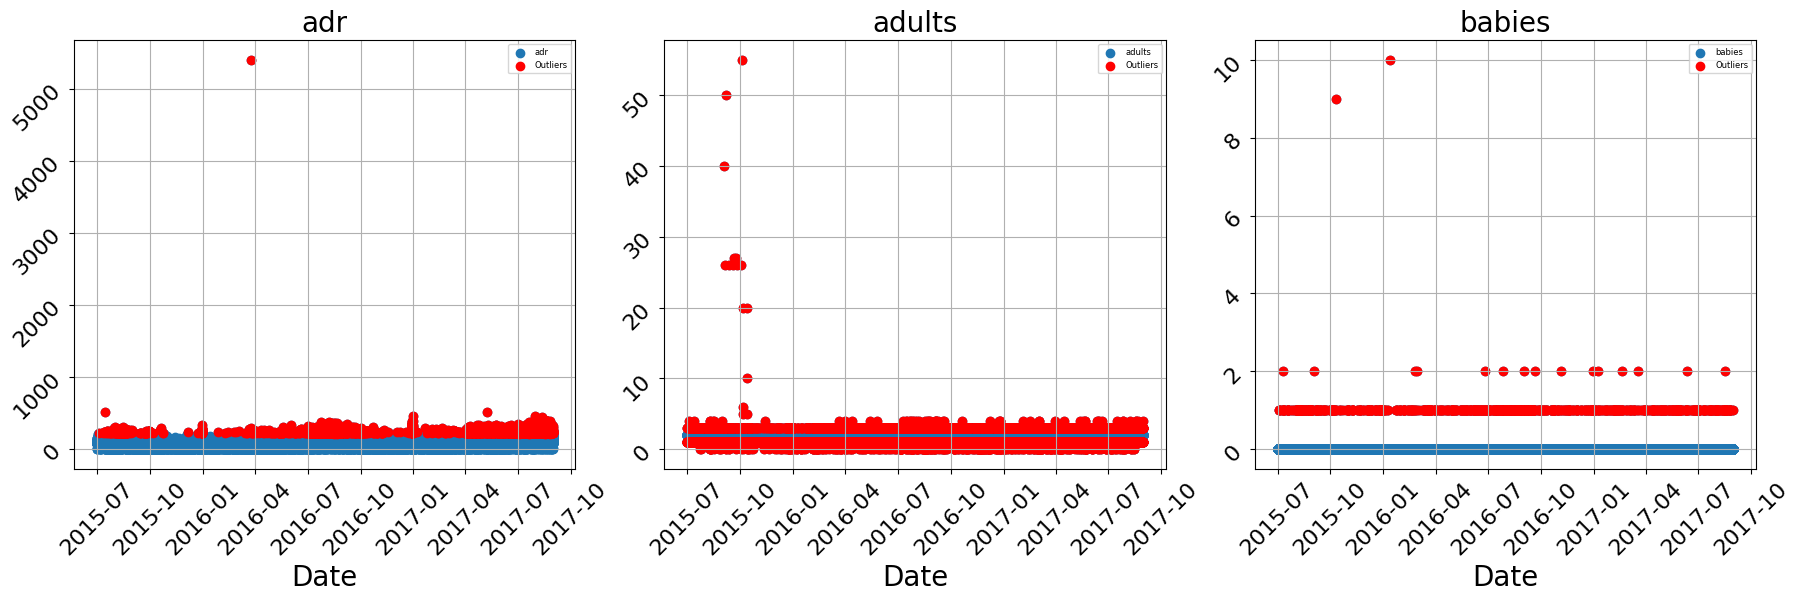

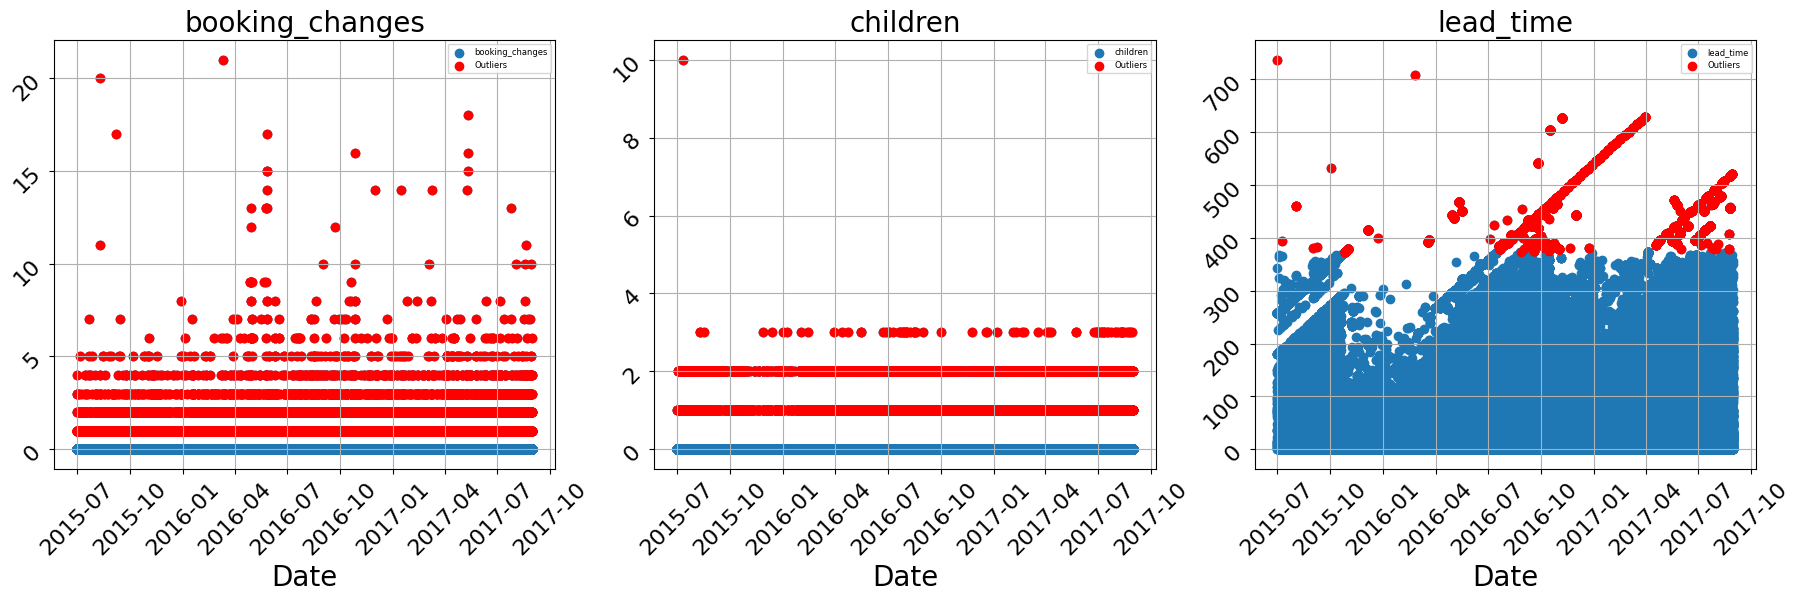

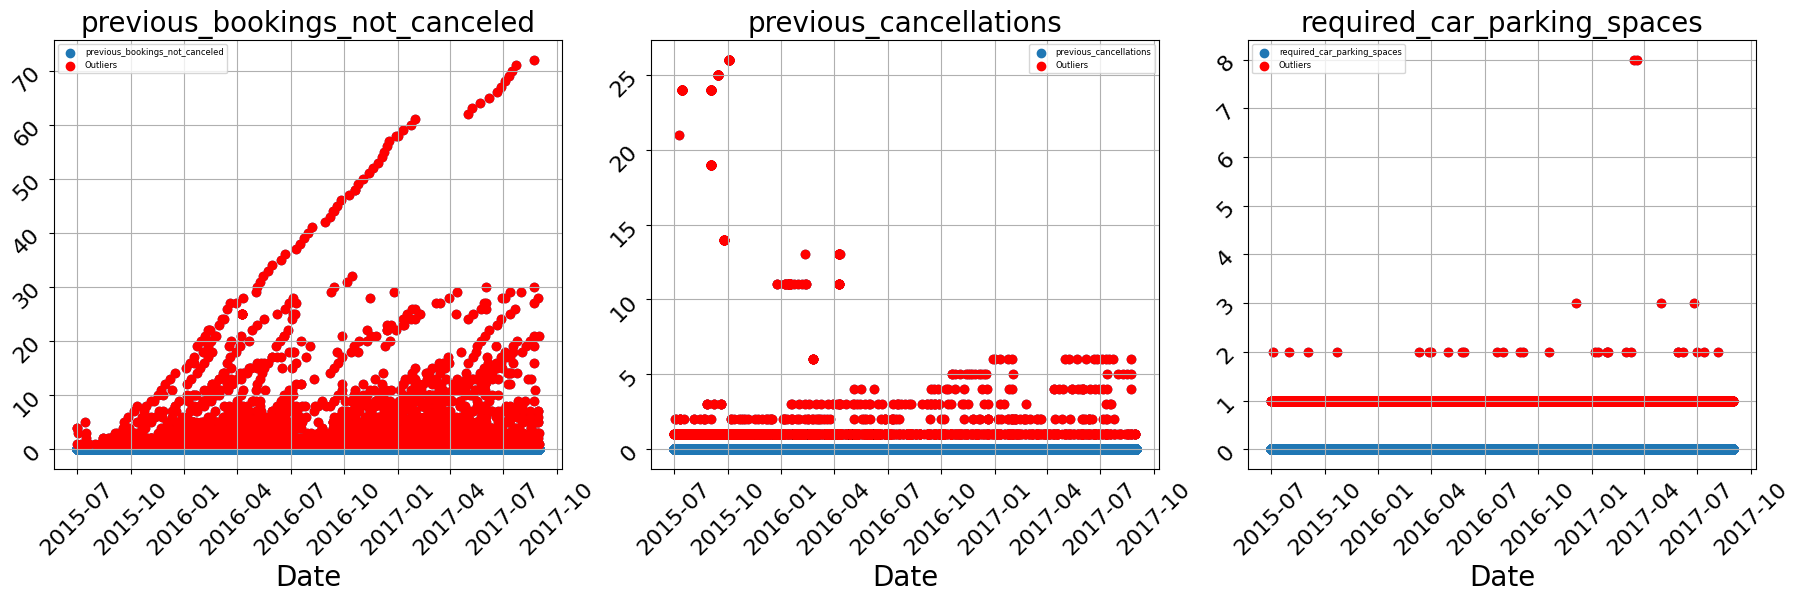

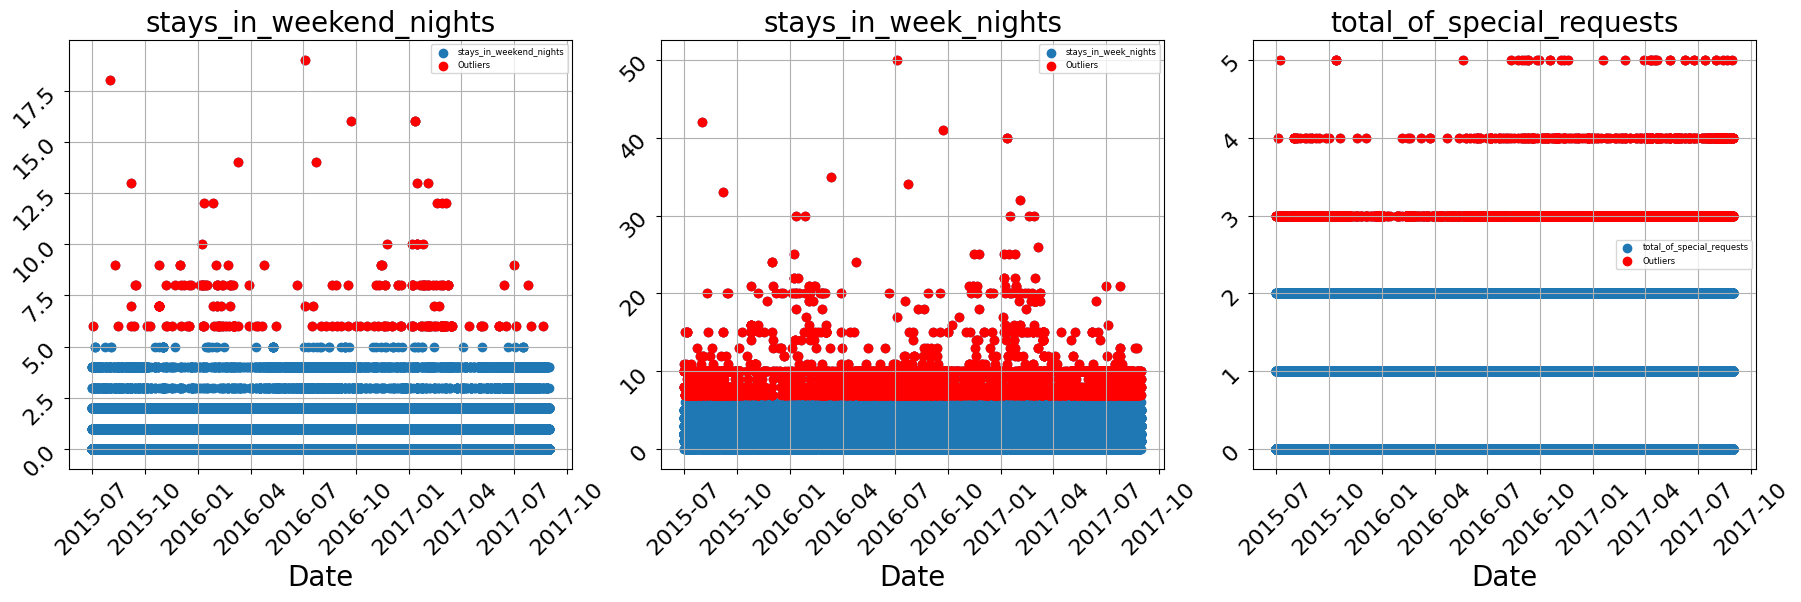

In [97]:
index = ['adr', 'adults', 'babies', 'booking_changes', 'children', 
         'lead_time', 'previous_bookings_not_canceled', 'previous_cancellations', 
         'required_car_parking_spaces', 'stays_in_weekend_nights','stays_in_week_nights','total_of_special_requests']

# Calculate number of rows needed
num_rows = int(np.ceil(len(index) / 3))

# Iterate through the indices and create plots
for i in range(num_rows):
    # Create a subplot with three columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot each index in the current row
    for j in range(3):
        idx = i * 3 + j
        if idx < len(index):
            col = index[idx]
            # Calculate outliers
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Identify outliers
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

            # Plotting
            axes[j].scatter(df['date'], df[col], label=col)
            axes[j].scatter(outliers['date'], outliers[col], color='red', label='Outliers')

            # Formatting
            axes[j].set_title(col, fontsize=20)
            axes[j].set_xlabel('Date', fontsize=20)
            axes[j].grid(True)
            axes[j].tick_params(rotation=45)
            axes[j].tick_params(axis='both', labelsize=16)  # Increase font size for both axes ticks
            axes[j].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

## Remove numeric and categorical outliers

In [98]:
# Numeric
df = df[df['adr'] <5000]

## Exploratory Data Analysis

### Counts

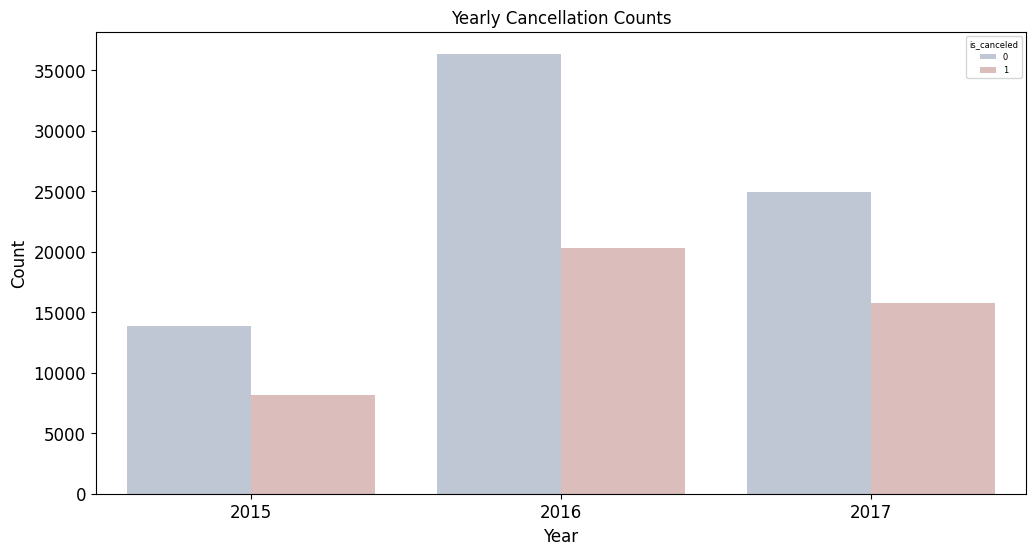

In [108]:
year_df = pd.DataFrame(df.groupby(['arrival_date_year','is_canceled'])['is_canceled'].count())
year_df.rename(columns={'is_canceled': 'count'}, inplace=True)

plt.figure(figsize=(12,6))
ax = sns.barplot(x='arrival_date_year', y='count',hue='is_canceled', data= year_df, palette='vlag')
plt.title('Yearly Cancellation Counts', fontsize=12)

# Set x-axis label
ax.set_xlabel('Year', fontsize=12)

# Set y-axis label
ax.set_ylabel('Count', fontsize=12)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


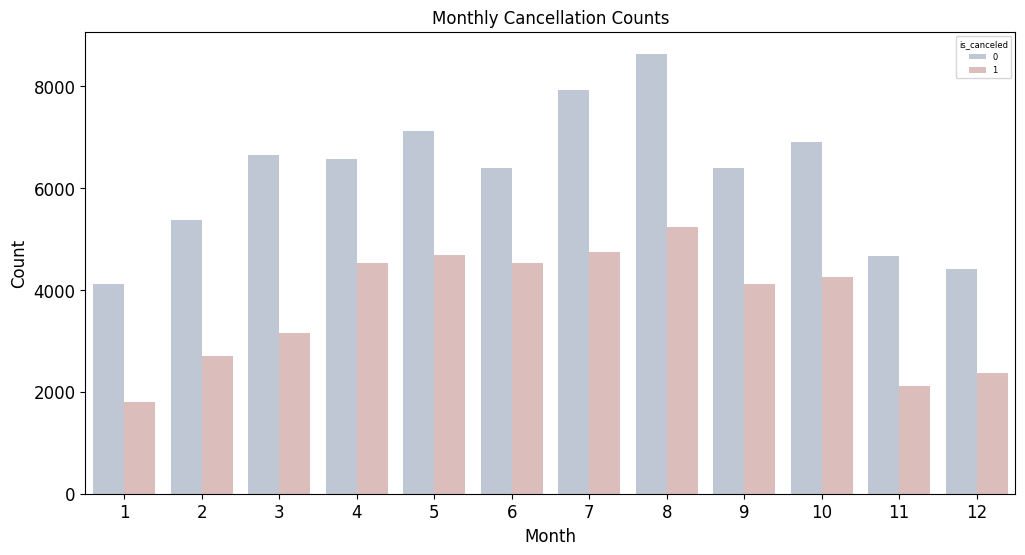

In [109]:
year_df = pd.DataFrame(df.groupby(['arrival_date_month','is_canceled'])['is_canceled'].count())
year_df.rename(columns={'is_canceled': 'count'}, inplace=True)

plt.figure(figsize=(12,6))
ax = sns.barplot(x='arrival_date_month', y='count',hue='is_canceled', data= year_df, palette='vlag')
plt.title('Monthly Cancellation Counts', fontsize=12)

# Set x-axis label
ax.set_xlabel('Month', fontsize=12)

# Set y-axis label
ax.set_ylabel('Count', fontsize=12)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

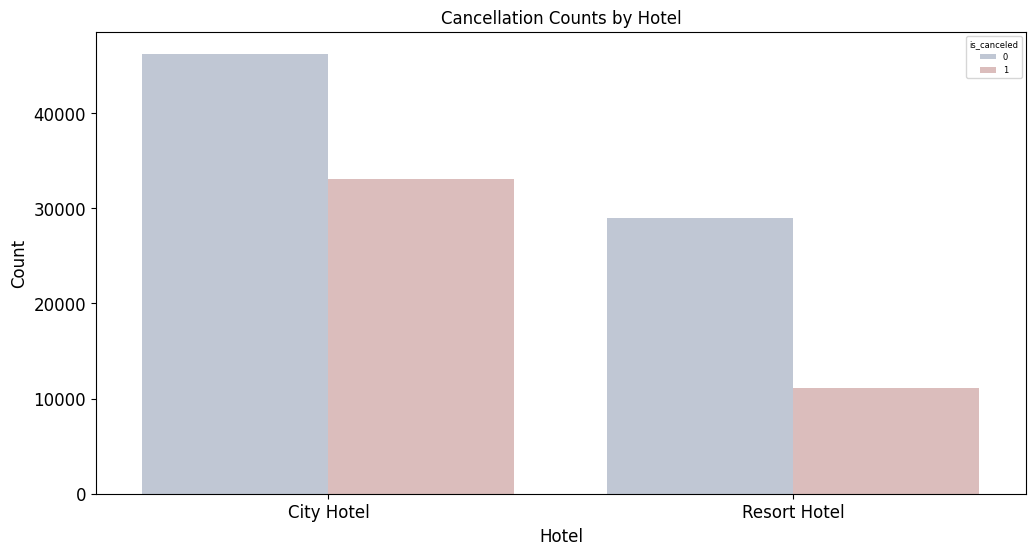

In [110]:
year_df = pd.DataFrame(df.groupby(['hotel','is_canceled'])['is_canceled'].count())
year_df.rename(columns={'is_canceled': 'count'}, inplace=True)

plt.figure(figsize=(12,6))
ax = sns.barplot(x='hotel', y='count',hue='is_canceled', data= year_df, palette='vlag')
plt.title('Cancellation Counts by Hotel', fontsize=12)

# Set x-axis label
ax.set_xlabel('Hotel', fontsize=12)

# Set y-axis label
ax.set_ylabel('Count', fontsize=12)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

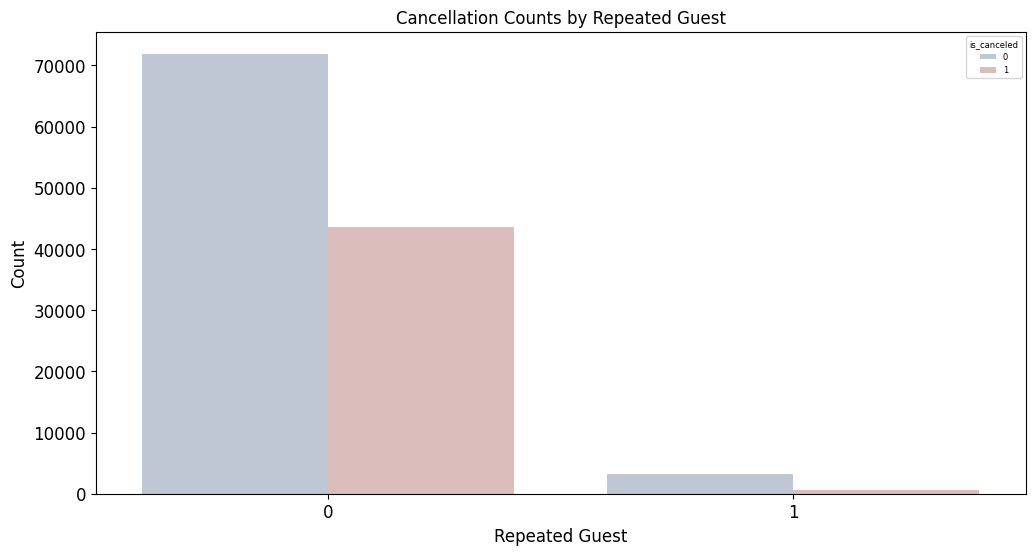

In [111]:
year_df = pd.DataFrame(df.groupby(['is_repeated_guest','is_canceled'])['is_canceled'].count())
year_df.rename(columns={'is_canceled': 'count'}, inplace=True)

plt.figure(figsize=(12,6))
ax = sns.barplot(x='is_repeated_guest', y='count',hue='is_canceled', data= year_df, palette='vlag')
plt.title('Cancellation Counts by Repeated Guest', fontsize=12)

# Set x-axis label
ax.set_xlabel('Repeated Guest', fontsize=12)

# Set y-axis label
ax.set_ylabel('Count', fontsize=12)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

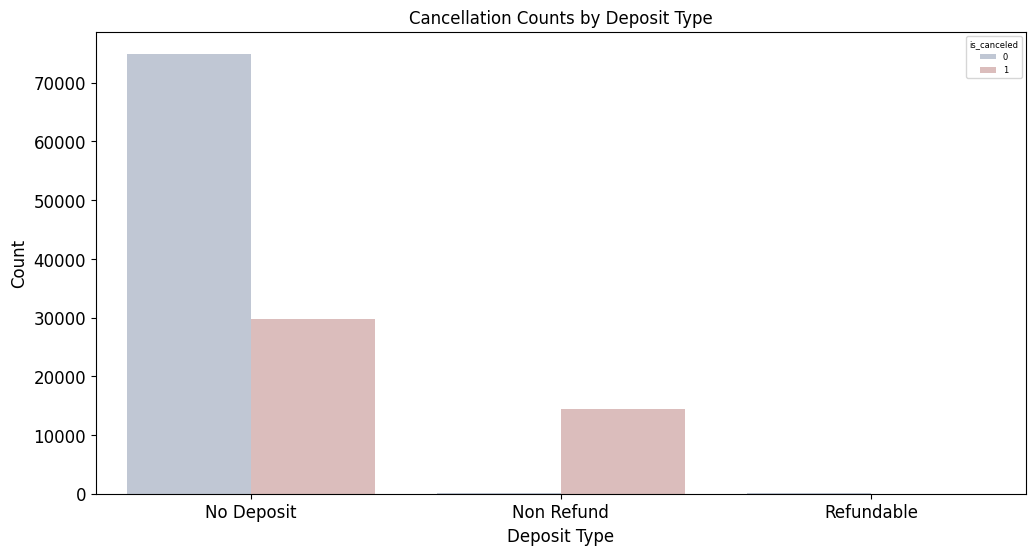

In [112]:
year_df = pd.DataFrame(df.groupby(['deposit_type','is_canceled'])['is_canceled'].count())
year_df.rename(columns={'is_canceled': 'count'}, inplace=True)

plt.figure(figsize=(12,6))
ax = sns.barplot(x='deposit_type', y='count',hue='is_canceled', data= year_df, palette='vlag')
plt.title('Cancellation Counts by Deposit Type', fontsize=12)

# Set x-axis label
ax.set_xlabel('Deposit Type', fontsize=12)

# Set y-axis label
ax.set_ylabel('Count', fontsize=12)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

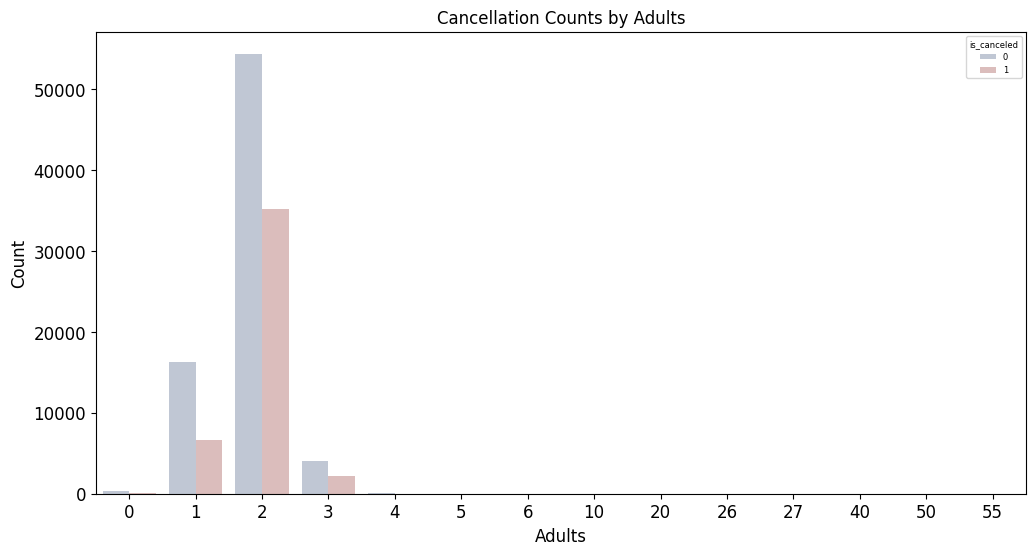

In [113]:
year_df = pd.DataFrame(df.groupby(['adults','is_canceled'])['is_canceled'].count())
year_df.rename(columns={'is_canceled': 'count'}, inplace=True)

plt.figure(figsize=(12,6))
ax = sns.barplot(x='adults', y='count',hue='is_canceled', data= year_df, palette='vlag')
plt.title('Cancellation Counts by Adults', fontsize=12)

# Set x-axis label
ax.set_xlabel('Adults', fontsize=12)

# Set y-axis label
ax.set_ylabel('Count', fontsize=12)


ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

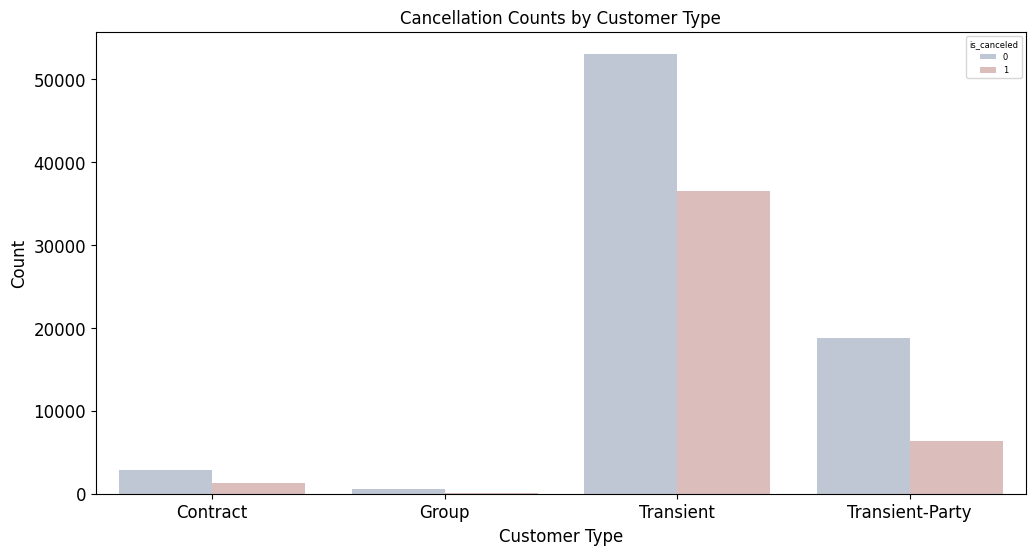

In [114]:
year_df = pd.DataFrame(df.groupby(['customer_type','is_canceled'])['is_canceled'].count())
year_df.rename(columns={'is_canceled': 'count'}, inplace=True)

plt.figure(figsize=(12,6))
ax = sns.barplot(x='customer_type', y='count',hue='is_canceled', data= year_df, palette='vlag')
plt.title('Cancellation Counts by Customer Type', fontsize=12)

# Set x-axis label
ax.set_xlabel('Customer Type', fontsize=12)

# Set y-axis label
ax.set_ylabel('Count', fontsize=12)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

### Percentage

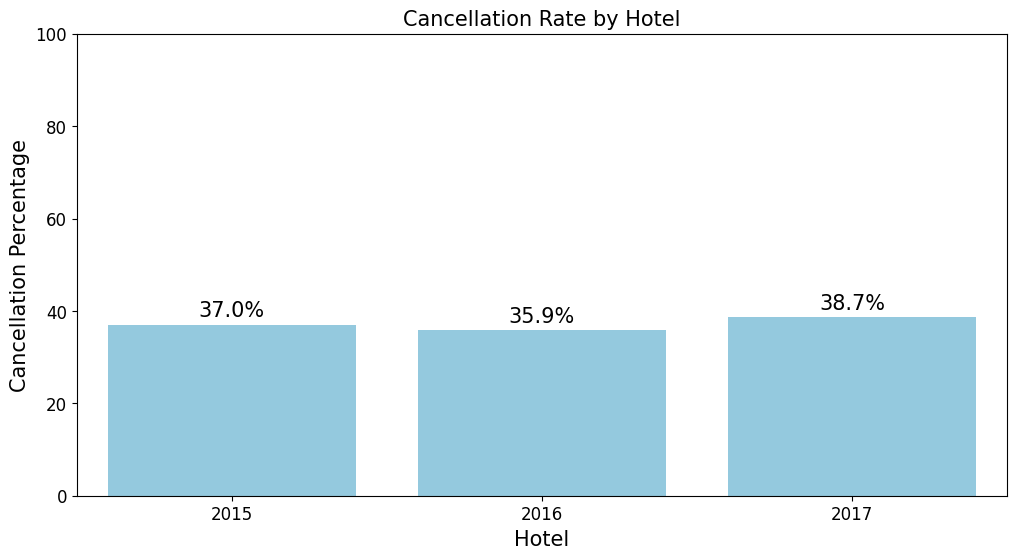

In [57]:
# Group by year and cancellation status, and count the occurrences
year_df = df.groupby(['arrival_date_year', 'is_canceled']).size().unstack(fill_value=0)

# Calculate the percentage of cancellations for each year
year_df['total'] = year_df.sum(axis=1)
year_df['percent_canceled'] = (year_df[1] / year_df['total']) * 100

# Plotting
plt.figure(figsize=(12,6))
ax = sns.barplot(x=year_df.index, y=year_df['percent_canceled'], color='skyblue')
plt.title('Cancellation Rate by Hotel',fontsize=15)
plt.xlabel('Hotel',fontsize=15)
plt.ylabel('Cancellation Percentage',fontsize=15)

# Add percentage labels on the bars
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=15)

plt.ylim(0, 100)  # Set y-axis limit to 100
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


plt.show()

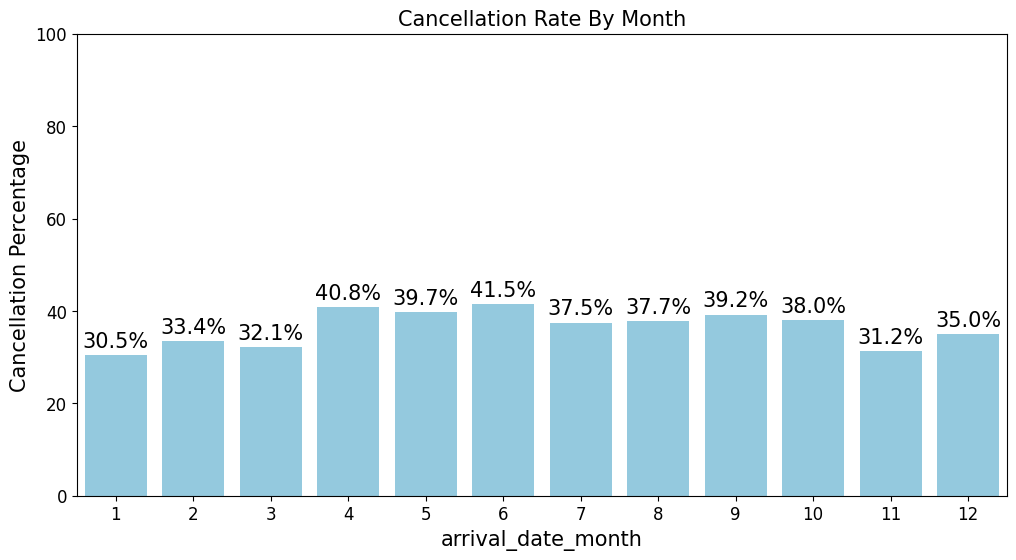

In [64]:
# Group by year and cancellation status, and count the occurrences
year_df = df.groupby(['arrival_date_month', 'is_canceled']).size().unstack(fill_value=0)

# Calculate the percentage of cancellations for each year
year_df['total'] = year_df.sum(axis=1)
year_df['percent_canceled'] = (year_df[1] / year_df['total']) * 100

# Plotting
plt.figure(figsize=(12,6))
ax = sns.barplot(x=year_df.index, y=year_df['percent_canceled'], color='skyblue')
plt.title('Cancellation Rate By Month',fontsize=15)
plt.xlabel('arrival_date_month',fontsize=15)
plt.ylabel('Cancellation Percentage',fontsize=15)

# Add percentage labels on the bars
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=15)

plt.ylim(0, 100)  # Set y-axis limit to 100
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.show()

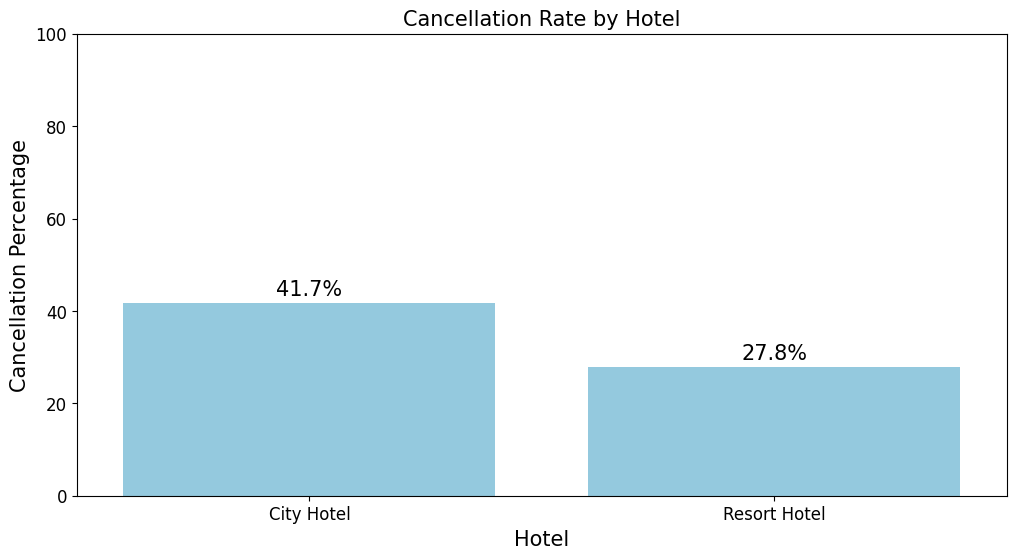

In [30]:
# Group by year and cancellation status, and count the occurrences
year_df = df.groupby(['hotel', 'is_canceled']).size().unstack(fill_value=0)

# Calculate the percentage of cancellations for each year
year_df['total'] = year_df.sum(axis=1)
year_df['percent_canceled'] = (year_df[1] / year_df['total']) * 100

# Plotting
plt.figure(figsize=(12,6))
ax = sns.barplot(x=year_df.index, y=year_df['percent_canceled'], color='skyblue')
plt.title('Cancellation Rate by Hotel',fontsize=15)
plt.xlabel('Hotel',fontsize=15)
plt.ylabel('Cancellation Percentage',fontsize=15)

# Add percentage labels on the bars
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=15)

plt.ylim(0, 100)  # Set y-axis limit to 100
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


plt.show()

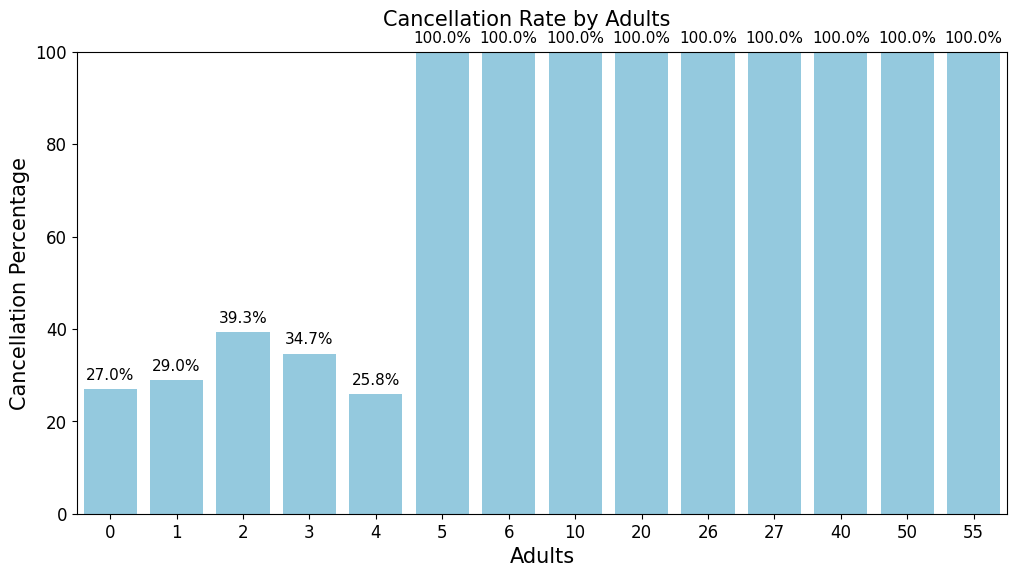

In [67]:
# Group by year and cancellation status, and count the occurrences
year_df = df.groupby(['adults', 'is_canceled']).size().unstack(fill_value=0)

# Calculate the percentage of cancellations for each year
year_df['total'] = year_df.sum(axis=1)
year_df['percent_canceled'] = (year_df[1] / year_df['total']) * 100

# Plotting
plt.figure(figsize=(12,6))
ax = sns.barplot(x=year_df.index, y=year_df['percent_canceled'], color='skyblue')
plt.suptitle('Cancellation Rate by Adults', fontsize=15, y=0.95) 
plt.xlabel('Adults',fontsize=15)
plt.ylabel('Cancellation Percentage',fontsize=15)

# Add percentage labels on the bars
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=11)

plt.ylim(0, 100)  # Set y-axis limit to 100
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


plt.show()

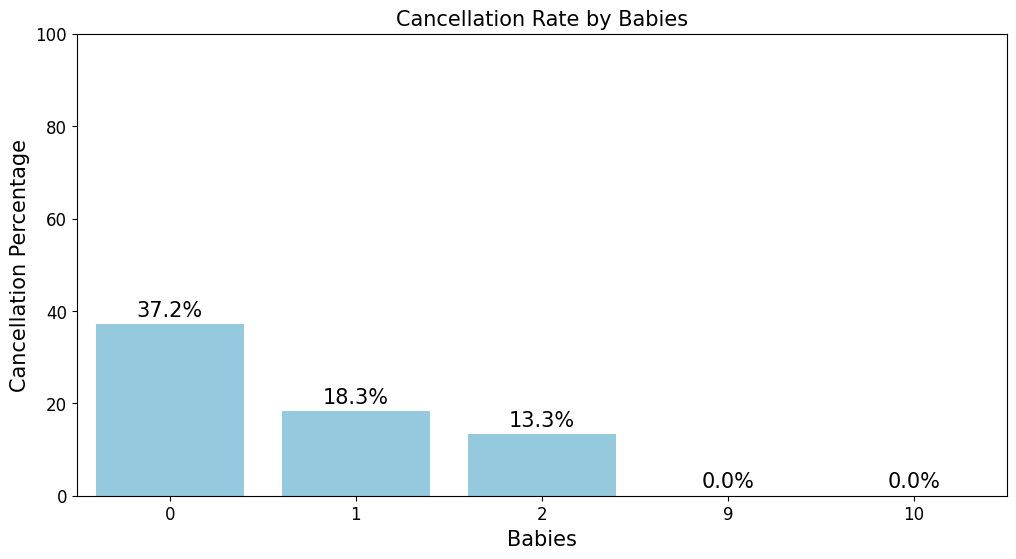

In [74]:
# Group by year and cancellation status, and count the occurrences
year_df = df.groupby(['babies', 'is_canceled']).size().unstack(fill_value=0)

# Calculate the percentage of cancellations for each year
year_df['total'] = year_df.sum(axis=1)
year_df['percent_canceled'] = (year_df[1] / year_df['total']) * 100

# Plotting
plt.figure(figsize=(12,6))
ax = sns.barplot(x=year_df.index, y=year_df['percent_canceled'], color='skyblue')
plt.title('Cancellation Rate by Babies',fontsize=15)
plt.xlabel('Babies',fontsize=15)
plt.ylabel('Cancellation Percentage',fontsize=15)

# Add percentage labels on the bars
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=15)

plt.ylim(0, 100)  # Set y-axis limit to 100
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


plt.show()

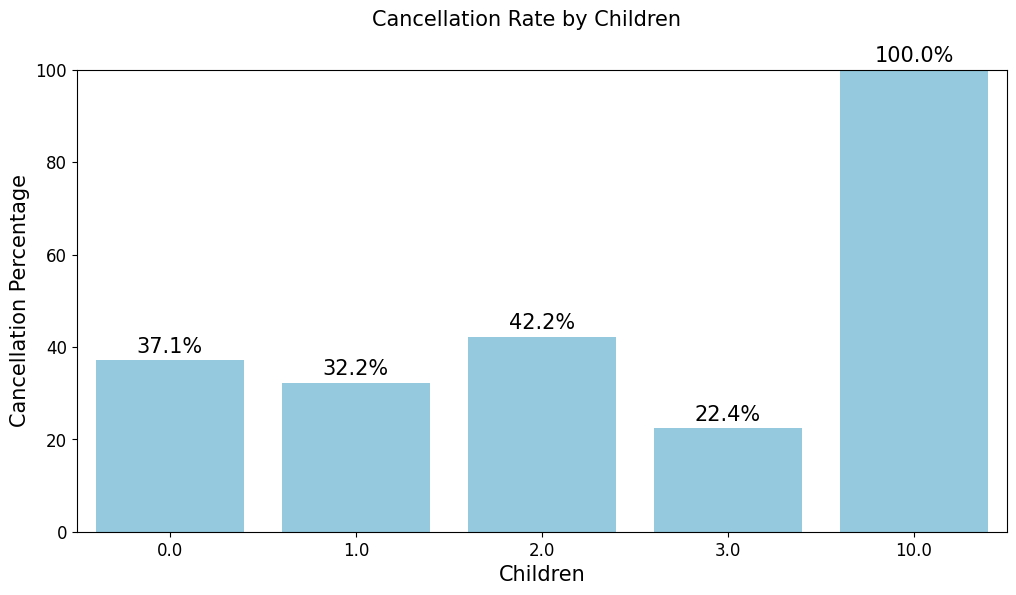

In [75]:
# Group by year and cancellation status, and count the occurrences
year_df = df.groupby(['children', 'is_canceled']).size().unstack(fill_value=0)

# Calculate the percentage of cancellations for each year
year_df['total'] = year_df.sum(axis=1)
year_df['percent_canceled'] = (year_df[1] / year_df['total']) * 100

# Plotting
plt.figure(figsize=(12,6))
ax = sns.barplot(x=year_df.index, y=year_df['percent_canceled'], color='skyblue')
plt.suptitle('Cancellation Rate by Children',fontsize=15)
plt.xlabel('Children',fontsize=15)
plt.ylabel('Cancellation Percentage',fontsize=15)

# Add percentage labels on the bars
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=15)

plt.ylim(0, 100)  # Set y-axis limit to 100
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


plt.show()

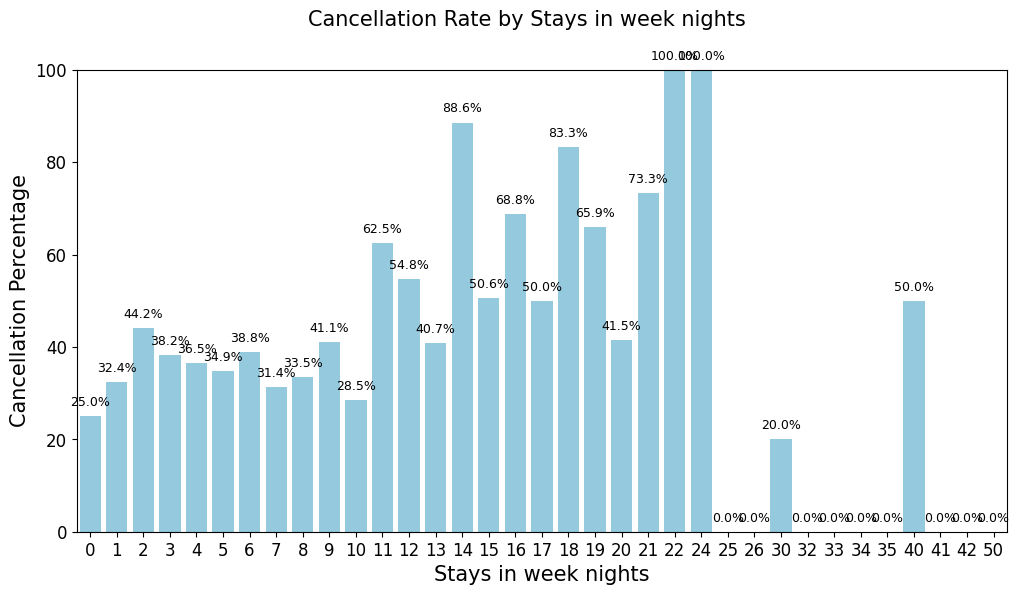

In [76]:
# Group by year and cancellation status, and count the occurrences
year_df = df.groupby(['stays_in_week_nights', 'is_canceled']).size().unstack(fill_value=0)

# Calculate the percentage of cancellations for each year
year_df['total'] = year_df.sum(axis=1)
year_df['percent_canceled'] = (year_df[1] / year_df['total']) * 100

# Plotting
plt.figure(figsize=(12,6))
ax = sns.barplot(x=year_df.index, y=year_df['percent_canceled'], color='skyblue')
plt.suptitle('Cancellation Rate by Stays in week nights',fontsize=15)
plt.xlabel('Stays in week nights',fontsize=15)
plt.ylabel('Cancellation Percentage',fontsize=15)

# Add percentage labels on the bars
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=9)

plt.ylim(0, 100)  # Set y-axis limit to 100
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


plt.show()

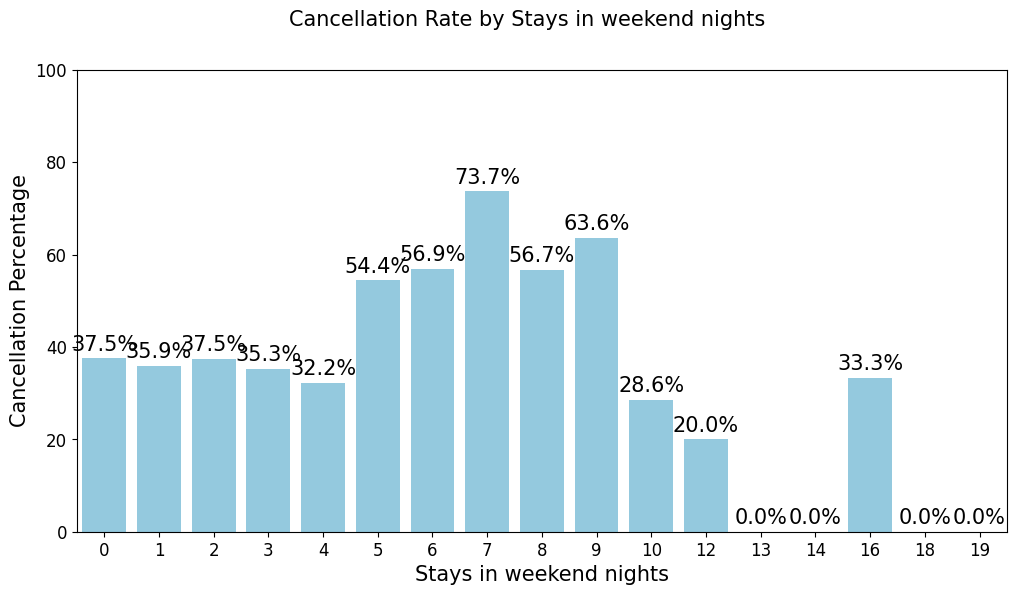

In [77]:
# Group by year and cancellation status, and count the occurrences
year_df = df.groupby(['stays_in_weekend_nights', 'is_canceled']).size().unstack(fill_value=0)

# Calculate the percentage of cancellations for each year
year_df['total'] = year_df.sum(axis=1)
year_df['percent_canceled'] = (year_df[1] / year_df['total']) * 100

# Plotting
plt.figure(figsize=(12,6))
ax = sns.barplot(x=year_df.index, y=year_df['percent_canceled'], color='skyblue')
plt.suptitle('Cancellation Rate by Stays in weekend nights',fontsize=15)
plt.xlabel('Stays in weekend nights',fontsize=15)
plt.ylabel('Cancellation Percentage',fontsize=15)

# Add percentage labels on the bars
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=15)

plt.ylim(0, 100)  # Set y-axis limit to 100
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


plt.show()

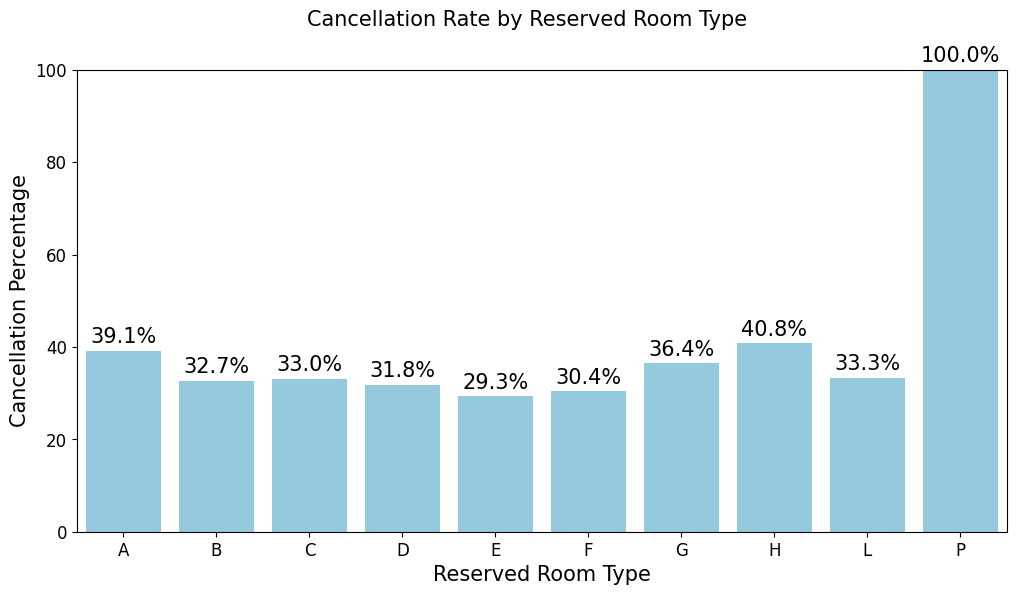

In [78]:
# Group by year and cancellation status, and count the occurrences
year_df = df.groupby(['reserved_room_type', 'is_canceled']).size().unstack(fill_value=0)

# Calculate the percentage of cancellations for each year
year_df['total'] = year_df.sum(axis=1)
year_df['percent_canceled'] = (year_df[1] / year_df['total']) * 100

# Plotting
plt.figure(figsize=(12,6))
ax = sns.barplot(x=year_df.index, y=year_df['percent_canceled'], color='skyblue')
plt.suptitle('Cancellation Rate by Reserved Room Type',fontsize=15)
plt.xlabel('Reserved Room Type',fontsize=15)
plt.ylabel('Cancellation Percentage',fontsize=15)

# Add percentage labels on the bars
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=15)

plt.ylim(0, 100)  # Set y-axis limit to 100
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


plt.show()

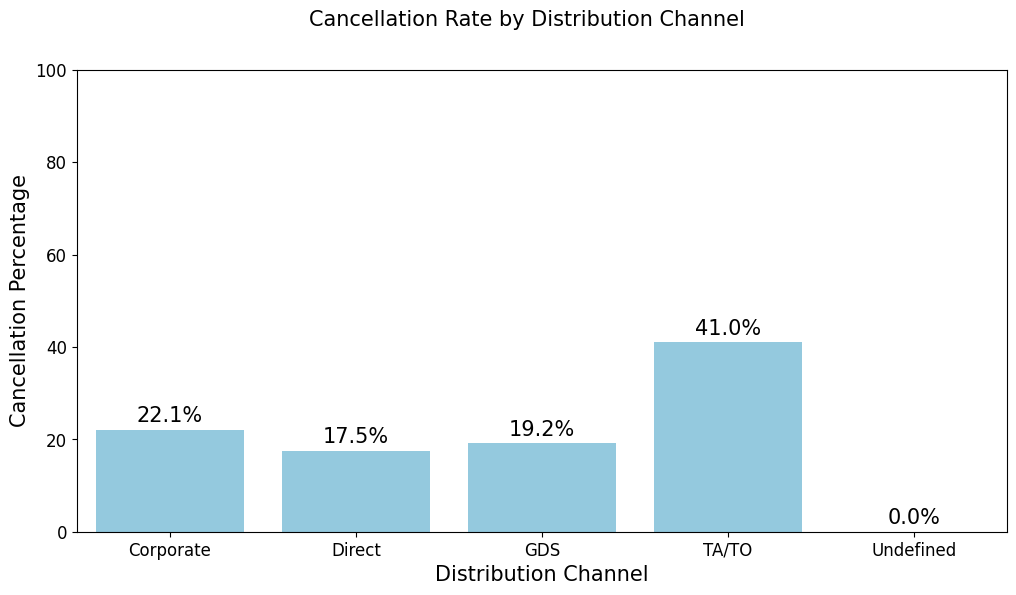

In [79]:
# Group by year and cancellation status, and count the occurrences
year_df = df.groupby(['distribution_channel', 'is_canceled']).size().unstack(fill_value=0)

# Calculate the percentage of cancellations for each year
year_df['total'] = year_df.sum(axis=1)
year_df['percent_canceled'] = (year_df[1] / year_df['total']) * 100

# Plotting
plt.figure(figsize=(12,6))
ax = sns.barplot(x=year_df.index, y=year_df['percent_canceled'], color='skyblue')
plt.suptitle('Cancellation Rate by Distribution Channel',fontsize=15)
plt.xlabel('Distribution Channel',fontsize=15)
plt.ylabel('Cancellation Percentage',fontsize=15)

# Add percentage labels on the bars
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=15)

plt.ylim(0, 100)  # Set y-axis limit to 100
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


plt.show()

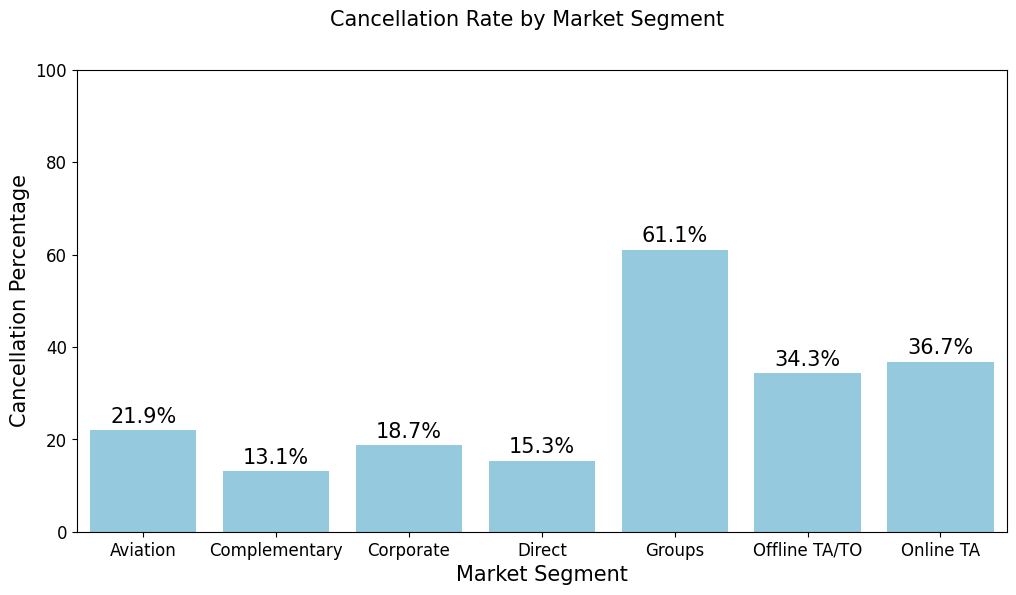

In [80]:
# Group by year and cancellation status, and count the occurrences
year_df = df.groupby(['market_segment', 'is_canceled']).size().unstack(fill_value=0)

# Calculate the percentage of cancellations for each year
year_df['total'] = year_df.sum(axis=1)
year_df['percent_canceled'] = (year_df[1] / year_df['total']) * 100

# Plotting
plt.figure(figsize=(12,6))
ax = sns.barplot(x=year_df.index, y=year_df['percent_canceled'], color='skyblue')
plt.suptitle('Cancellation Rate by Market Segment',fontsize=15)
plt.xlabel('Market Segment',fontsize=15)
plt.ylabel('Cancellation Percentage',fontsize=15)

# Add percentage labels on the bars
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=15)

plt.ylim(0, 100)  # Set y-axis limit to 100
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


plt.show()

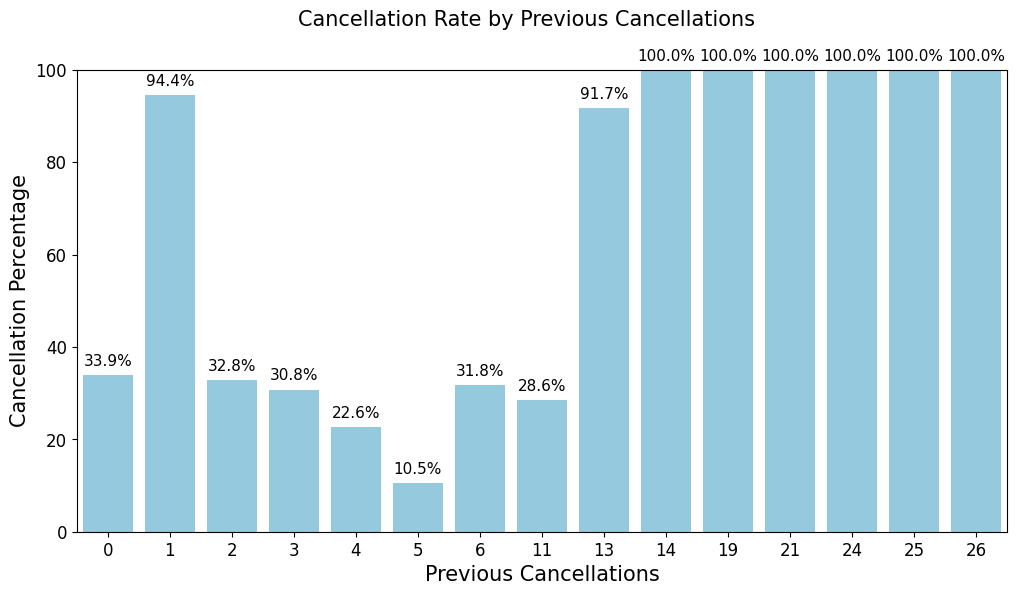

In [82]:
# Group by year and cancellation status, and count the occurrences
year_df = df.groupby(['previous_cancellations', 'is_canceled']).size().unstack(fill_value=0)

# Calculate the percentage of cancellations for each year
year_df['total'] = year_df.sum(axis=1)
year_df['percent_canceled'] = (year_df[1] / year_df['total']) * 100

# Plotting
plt.figure(figsize=(12,6))
ax = sns.barplot(x=year_df.index, y=year_df['percent_canceled'], color='skyblue')
plt.suptitle('Cancellation Rate by Previous Cancellations',fontsize=15)
plt.xlabel('Previous Cancellations',fontsize=15)
plt.ylabel('Cancellation Percentage',fontsize=15)

# Add percentage labels on the bars
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=11)

plt.ylim(0, 100)  # Set y-axis limit to 100
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


plt.show()

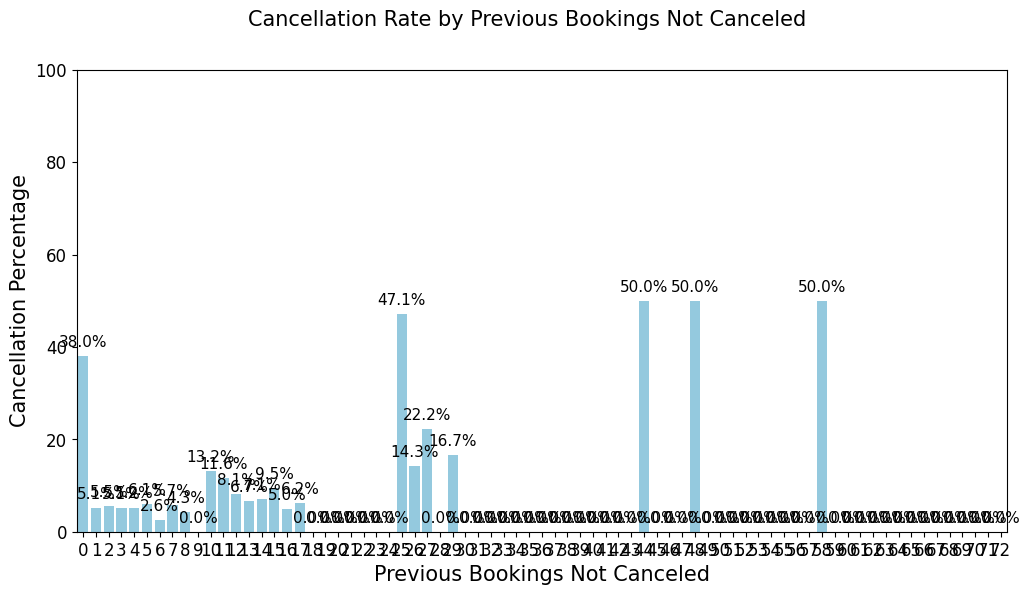

In [115]:
# Group by year and cancellation status, and count the occurrences
year_df = df.groupby(['previous_bookings_not_canceled', 'is_canceled']).size().unstack(fill_value=0)

# Calculate the percentage of cancellations for each year
year_df['total'] = year_df.sum(axis=1)
year_df['percent_canceled'] = (year_df[1] / year_df['total']) * 100

# Plotting
plt.figure(figsize=(12,6))
ax = sns.barplot(x=year_df.index, y=year_df['percent_canceled'], color='skyblue')
plt.suptitle('Cancellation Rate by Previous Bookings Not Canceled',fontsize=15)
plt.xlabel('Previous Bookings Not Canceled',fontsize=15)
plt.ylabel('Cancellation Percentage',fontsize=15)

# Add percentage labels on the bars
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=11)

plt.ylim(0, 100)  # Set y-axis limit to 100
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


plt.show()

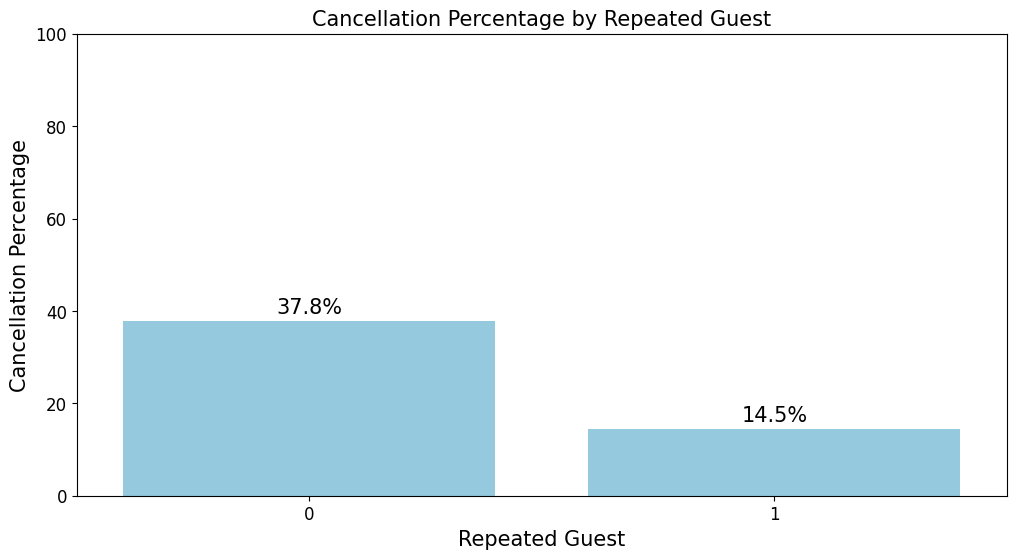

In [120]:
# Group by year and cancellation status, and count the occurrences
year_df = df.groupby(['is_repeated_guest', 'is_canceled']).size().unstack(fill_value=0)

# Calculate the percentage of cancellations for each year
year_df['total'] = year_df.sum(axis=1)
year_df['percent_canceled'] = (year_df[1] / year_df['total']) * 100

# Plotting
plt.figure(figsize=(12,6))
ax = sns.barplot(x=year_df.index, y=year_df['percent_canceled'], color='skyblue')
plt.title('Cancellation Percentage by Repeated Guest',fontsize=15)
plt.xlabel('Repeated Guest',fontsize=15)
plt.ylabel('Cancellation Percentage',fontsize=15)

# Add percentage labels on the bars
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=15)

plt.ylim(0, 100)  # Set y-axis limit to 100
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.show()

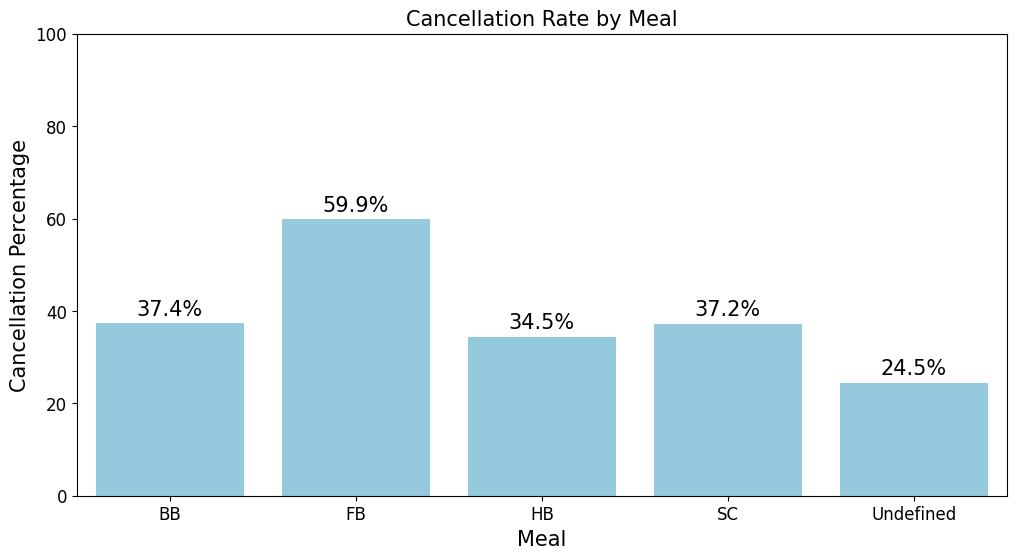

In [46]:
# Group by year and cancellation status, and count the occurrences
year_df = df.groupby(['meal', 'is_canceled']).size().unstack(fill_value=0)

# Calculate the percentage of cancellations for each year
year_df['total'] = year_df.sum(axis=1)
year_df['percent_canceled'] = (year_df[1] / year_df['total']) * 100

# Plotting
plt.figure(figsize=(12,6))
ax = sns.barplot(x=year_df.index, y=year_df['percent_canceled'], color='skyblue')
plt.title('Cancellation Rate by Meal',fontsize=15)
plt.xlabel('Meal',fontsize=15)
plt.ylabel('Cancellation Percentage',fontsize=15)

# Add percentage labels on the bars
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=15)

plt.ylim(0, 100)  # Set y-axis limit to 100
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


plt.show()

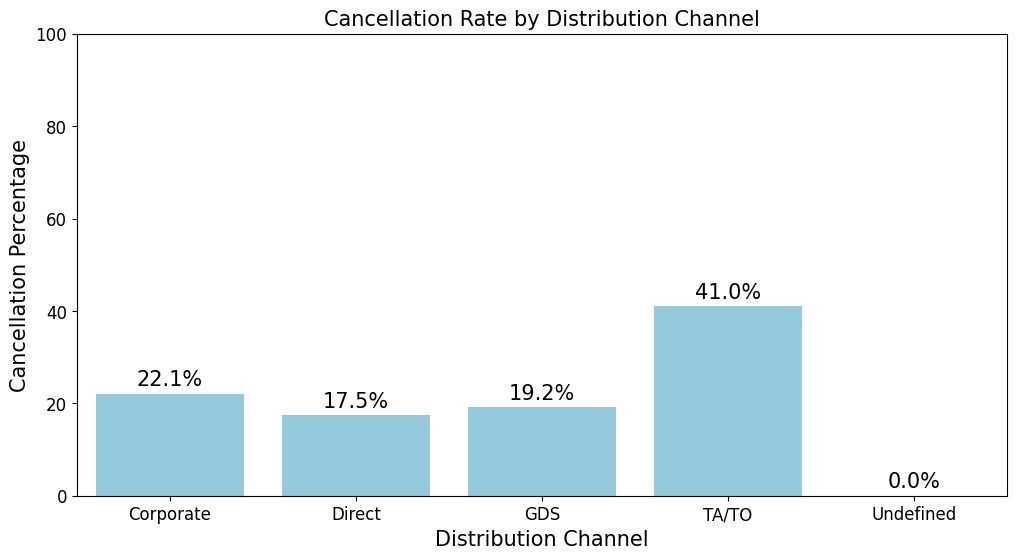

In [47]:
# Group by year and cancellation status, and count the occurrences
year_df = df.groupby(['distribution_channel', 'is_canceled']).size().unstack(fill_value=0)

# Calculate the percentage of cancellations for each year
year_df['total'] = year_df.sum(axis=1)
year_df['percent_canceled'] = (year_df[1] / year_df['total']) * 100

# Plotting
plt.figure(figsize=(12,6))
ax = sns.barplot(x=year_df.index, y=year_df['percent_canceled'], color='skyblue')
plt.title('Cancellation Rate by Distribution Channel',fontsize=15)
plt.xlabel('Distribution Channel',fontsize=15)
plt.ylabel('Cancellation Percentage',fontsize=15)

# Add percentage labels on the bars
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=15)

plt.ylim(0, 100)  # Set y-axis limit to 100
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


plt.show()

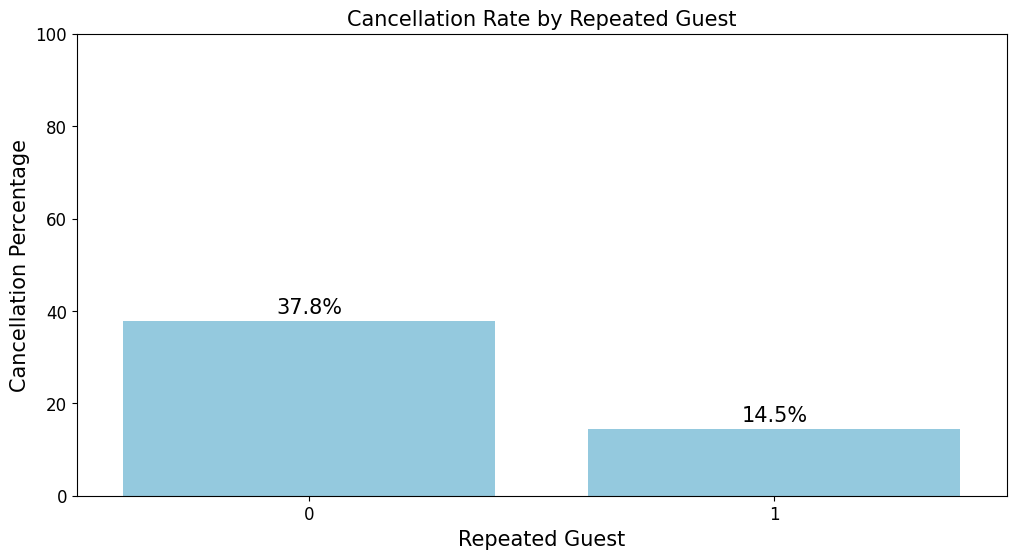

In [48]:
# Group by year and cancellation status, and count the occurrences
year_df = df.groupby(['is_repeated_guest', 'is_canceled']).size().unstack(fill_value=0)

# Calculate the percentage of cancellations for each year
year_df['total'] = year_df.sum(axis=1)
year_df['percent_canceled'] = (year_df[1] / year_df['total']) * 100

# Plotting
plt.figure(figsize=(12,6))
ax = sns.barplot(x=year_df.index, y=year_df['percent_canceled'], color='skyblue')
plt.title('Cancellation Rate by Repeated Guest',fontsize=15)
plt.xlabel('Repeated Guest',fontsize=15)
plt.ylabel('Cancellation Percentage',fontsize=15)

# Add percentage labels on the bars
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=15)

plt.ylim(0, 100)  # Set y-axis limit to 100
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


plt.show()

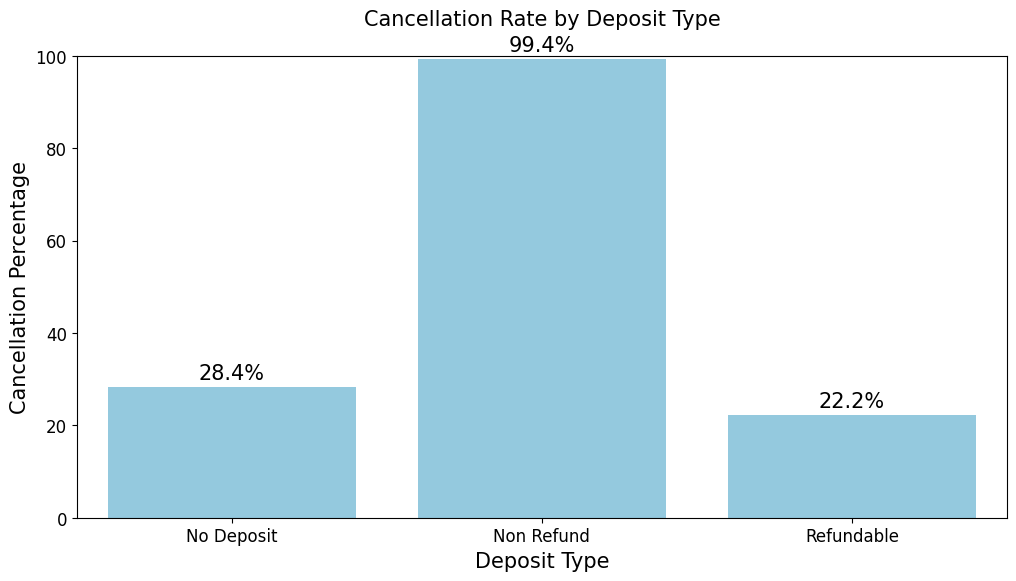

In [49]:
# Group by year and cancellation status, and count the occurrences
year_df = df.groupby(['deposit_type', 'is_canceled']).size().unstack(fill_value=0)

# Calculate the percentage of cancellations for each year
year_df['total'] = year_df.sum(axis=1)
year_df['percent_canceled'] = (year_df[1] / year_df['total']) * 100

# Plotting
plt.figure(figsize=(12,6))
ax = sns.barplot(x=year_df.index, y=year_df['percent_canceled'], color='skyblue')
plt.title('Cancellation Rate by Deposit Type',fontsize=15, pad=22)
plt.xlabel('Deposit Type',fontsize=15)
plt.ylabel('Cancellation Percentage',fontsize=15)

# Add percentage labels on the bars
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=15)

plt.ylim(0, 100)  # Set y-axis limit to 100
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


plt.show()

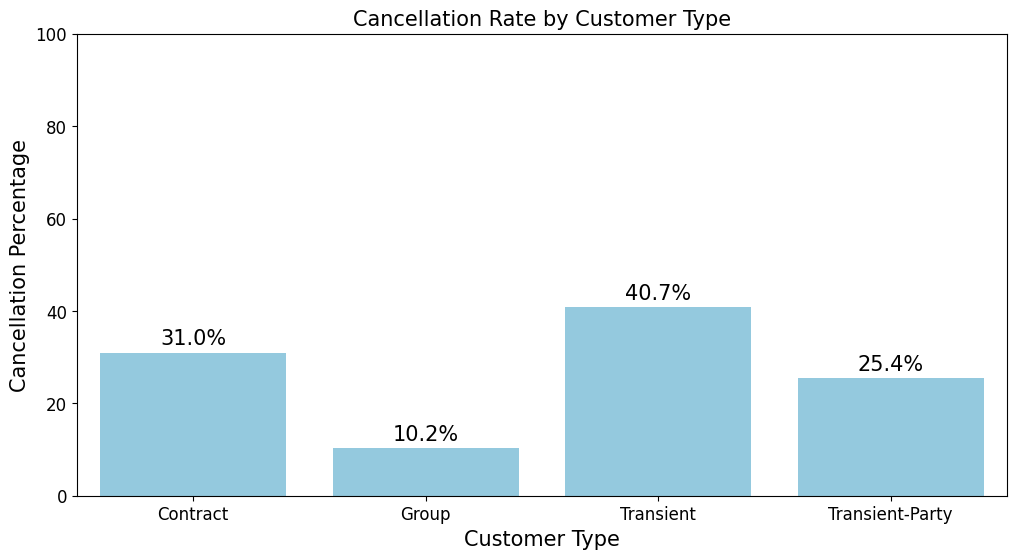

In [50]:
# Group by year and cancellation status, and count the occurrences
year_df = df.groupby(['customer_type', 'is_canceled']).size().unstack(fill_value=0)

# Calculate the percentage of cancellations for each year
year_df['total'] = year_df.sum(axis=1)
year_df['percent_canceled'] = (year_df[1] / year_df['total']) * 100

# Plotting
plt.figure(figsize=(12,6))
ax = sns.barplot(x=year_df.index, y=year_df['percent_canceled'], color='skyblue')
plt.title('Cancellation Rate by Customer Type',fontsize=15)
plt.xlabel('Customer Type',fontsize=15)
plt.ylabel('Cancellation Percentage',fontsize=15)

# Add percentage labels on the bars
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points',fontsize=15)

plt.ylim(0, 100)  # Set y-axis limit to 100
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


plt.show()

<Figure size 1200x600 with 0 Axes>

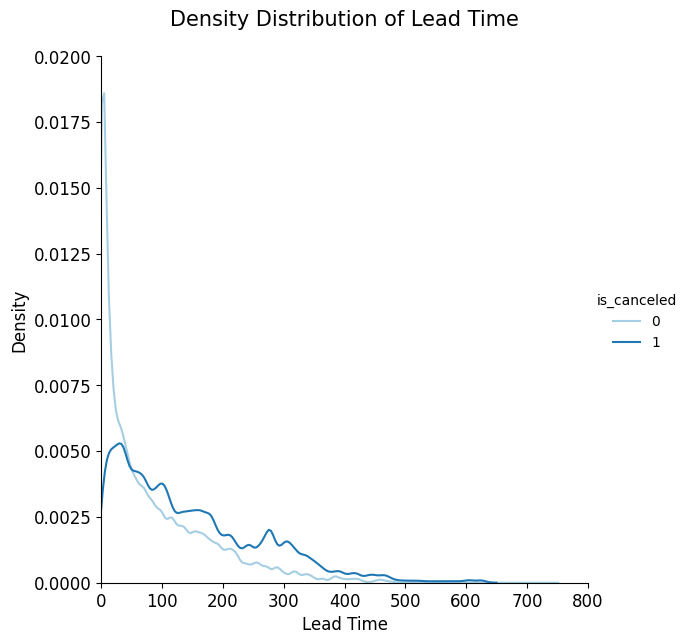

In [51]:
# Assuming 'df' is your dataframe and 'x' is the column containing continuous values,
# and 'iscancelled' is the column based on which you want to categorize the data
plt.figure(figsize=(12, 6))

# Create a FacetGrid with seaborn
g = sns.FacetGrid(df, hue="is_canceled", palette="Paired", height=6)

# Map the KDE plot on the FacetGrid
g.map(sns.kdeplot, 'lead_time', bw_adjust=0.5)

# Set x-axis limits
plt.xlim(0)

# Set titles and labels
g.set_axis_labels("Lead Time", "Density", fontsize=12)

# Add legend
g.add_legend()

# Set titles and labels
g.set_axis_labels("Lead Time", "Density")
g.set_xticklabels(fontsize=12)
g.set_yticklabels(fontsize=12)
plt.title('Density Distribution of Lead Time',fontsize=15, pad=22)
plt.show()

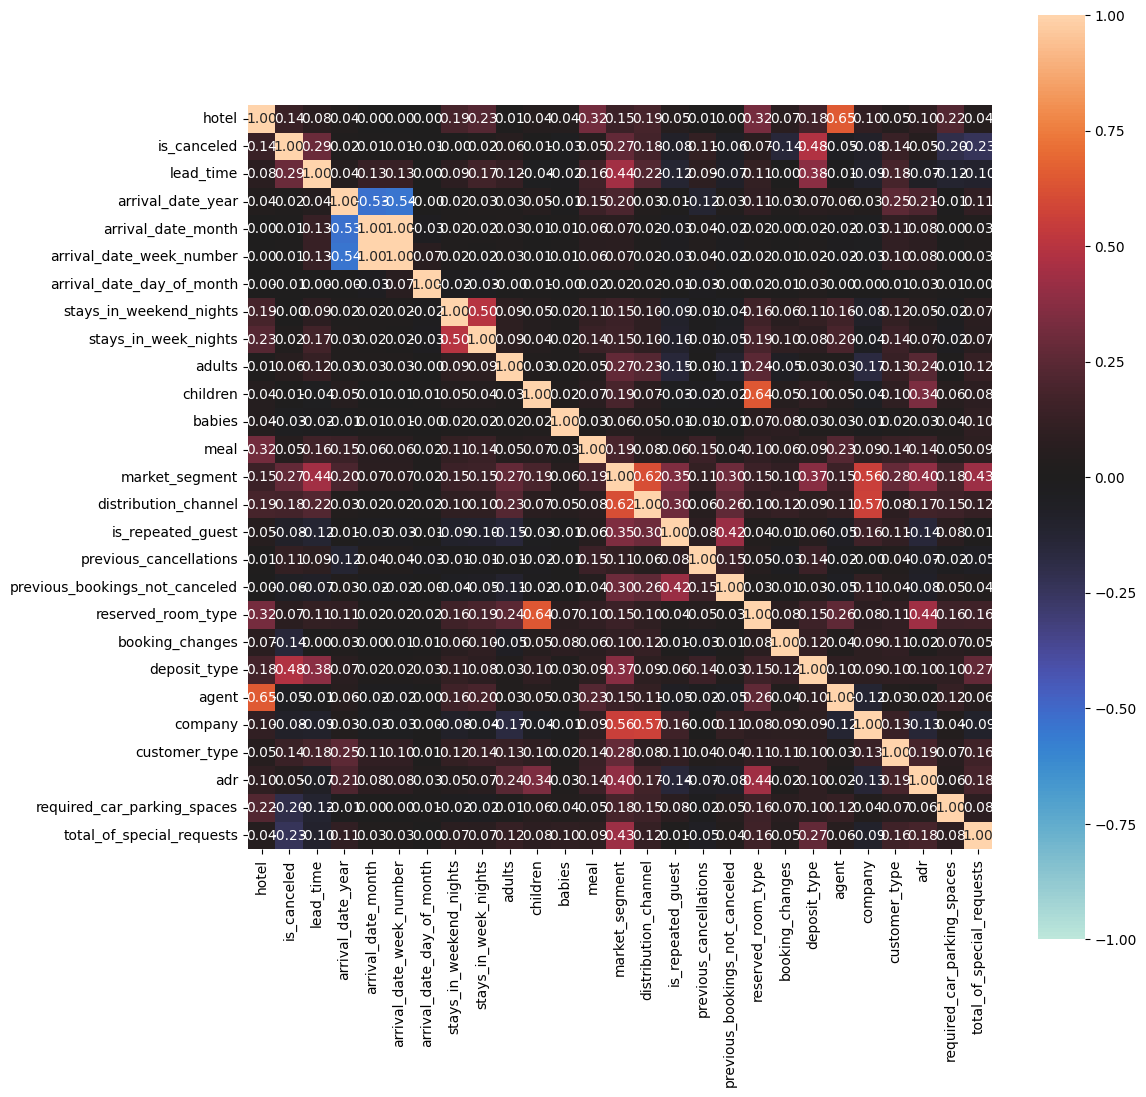

<Figure size 12000x12000 with 0 Axes>

<Figure size 12000x12000 with 0 Axes>

In [52]:
complete_correlation= associations(df.drop(columns=['date']), figsize=(12,12))
df_complete_corr=complete_correlation['corr']
df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='cool', axis=None)
# Set font size
plt.rcParams['font.size'] = 6 # You can adjust this value
cmap = sns.color_palette("cool", as_cmap=True)

# Create a larger figure
plt.figure(figsize=(12, 12), dpi=1000)  # Adjust the figure size as needed